# <center> Временные ряды</center>

    
  Временной ряд (time series) представляет собой последовательность хронологически упорядоченных числовых значений, отражающих течение некоторого процесса или явления. 

  Временные ряды возникают в широком спектре предметных областей:
- медицина - мониторинг показателей функциональной диагностики организма человека(временные ряды ЭКГ и ЭЭГ пациента)
- моделирование климата (временные ряды температуры воздуха, силы ветра в некоторой локации)
- финансовое прогнозирование (временные ряды
курсов акций и валют)
- генная инженерия (цепочки ДНК как временные ряды)
- в энергетике - цены, спрос, производственные графики
- розничная торговля - продажи, потребительский спрос на определенные товары

  

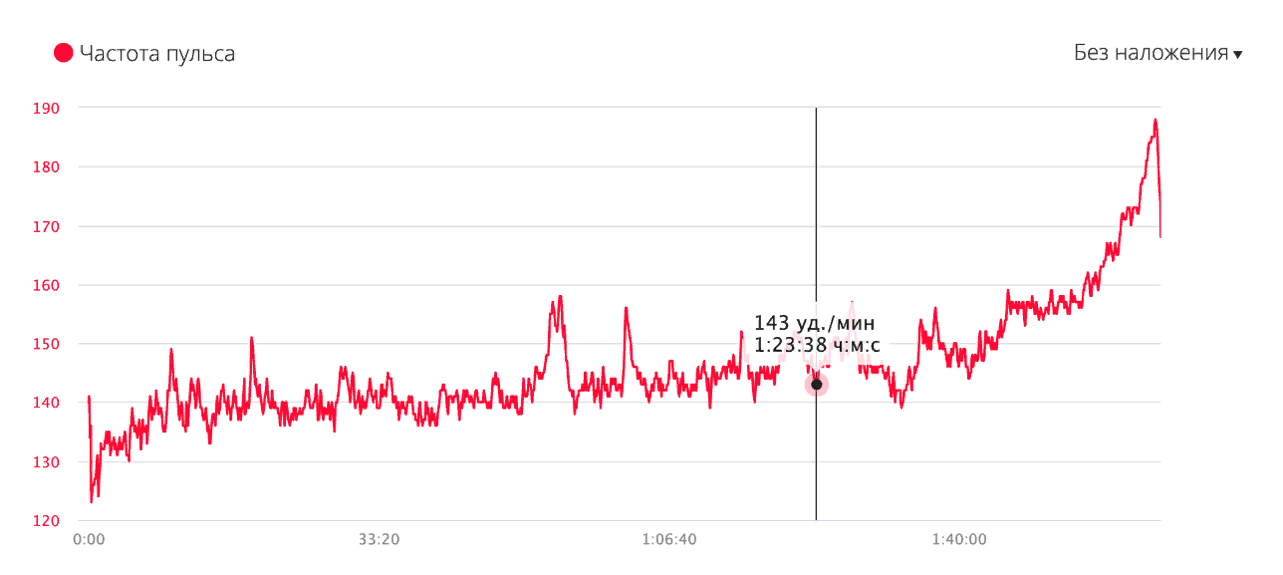

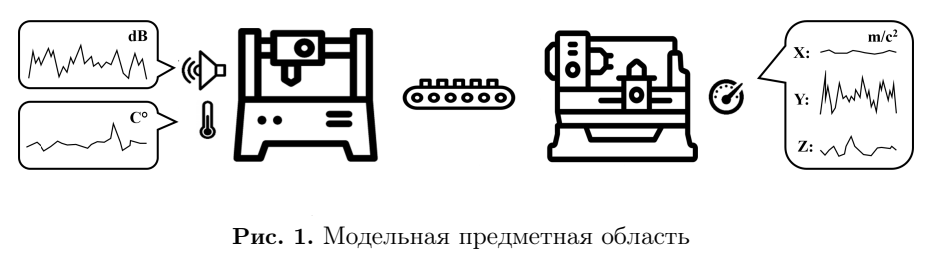

В настоящее время Интернета вещей (ИВ) представляют собой один из наиболее актуальных классов задач обработки временных рядов. 
В приложениях ИВ типичной является задача обеспечения умного управления и предиктивного технического обслуживания сложных машин и механизмов, которые оснащаются различными сенсорами. Такие сенсоры, как правило, имеют высокую дискретность снятия показаний (например, десятки раз в секунду) и за сравнительно короткое время продуцируют временные ряды длиной от десятков миллионов до миллиардов элементов. Получаемые с сенсоров данные временных рядов накапливаются и подвергаются интеллектуальному анализу, который позволяет выявить знания (скрытые тренды, аномалии и др.), необходимые для принятия стратегически важных решений.

Чаще всего возникает вопрос - а что у нас будет происходить с нашими показателями в ближайший день/неделю/месяц/пр. - сколько игроков установят приложения, сколько будет онлайна, как много действий совершат пользователи, и так далее. 

К задаче прогнозирования можно подходить по-разному, в зависимости от того, какого качества должен быть прогноз, на какой период мы хотим его строить, и, конечно, как долго нужно подбирать и настраивать параметры модели для его получения. 



#Начнем с простых методов анализа и прогнозирования - скользящих средних, сглаживаний и их вариаций.#
Импортируем нужные библиотеки. В основном нам понадобится модуль  [statsmodels](http://statsmodels.sourceforge.net/stable/), в котором реализованы многочисленные методы статистического моделирования, в том числе для временных рядов.

In [1]:
import sys
import warnings

warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

%matplotlib inline


from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)


Для примера возьмем реальные данные по часовому онлайну игроков в одной из мобильных игр.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

dir_data = './drive/MyDrive/SF/SF Webinars/Временные ряды/'
dataset = pd.read_csv(dir_data+'hour_online.csv')
dataset.tail()

Mounted at /content/drive


,Time,Users
2620,4/20/17 5:00,34833
2621,4/20/17 6:00,35932
2622,4/20/17 7:00,38418
2623,4/20/17 8:00,40238
2624,4/20/17 9:00,40763


In [3]:
dataset.shape

(2625, 2)

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [4]:
def moving_average(series, n):
    return np.average(series[-n:])


moving_average(dataset.Users, 24)  # посмотрим на прогноз, построенный по последнему наблюдаемому дню (24 часа)

29858.333333333332

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. 
Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. 
В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

In [5]:
def plotMovingAverage(series, n, plot_bounds=False):

    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """

    rolling_mean = series.rolling(window=n).mean()

    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_mean + 1.96 * rolling_std
        lower_bound = rolling_mean - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    # Отображать значение дат в формате yy-mm-dd
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
    plt.xticks(rotation=45)

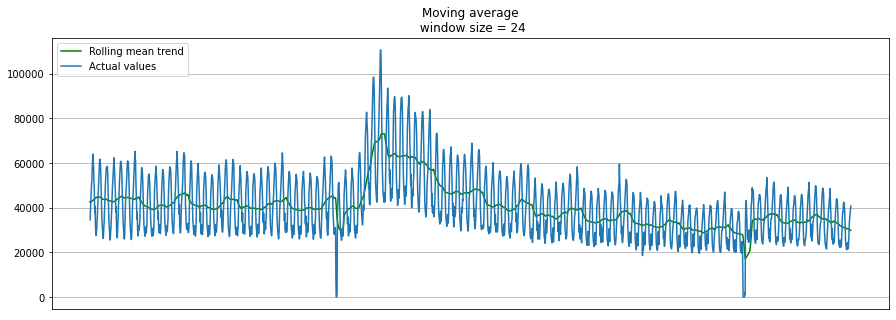

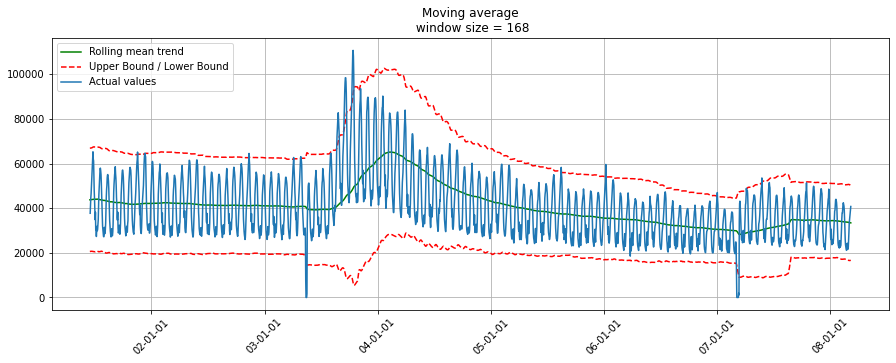

In [6]:
plotMovingAverage(dataset.Users, 24)  # сглаживаем по дням
plotMovingAverage(dataset.Users, 24*7, plot_bounds=True)  # сглаживаем по неделям

Для нашего ряда тренды и так вполне очевидны, но если сгладить по дням, становится лучше видна динамика онлайна по будням и выходным (выходные - время поиграть), а недельное сглаживание хорошо отражает общие изменения, связанные с резким ростом числа активных игроков в феврале и последующим снижением в марте.

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в суме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [7]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [8]:
weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

39907.43

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

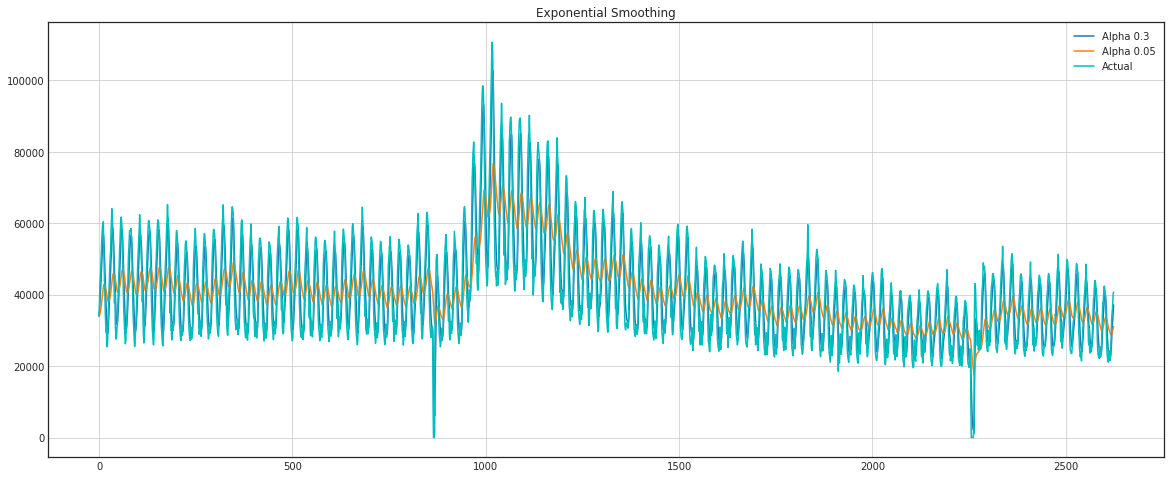

In [10]:
with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(
            exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha)
        )
    plt.plot(dataset.Users.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

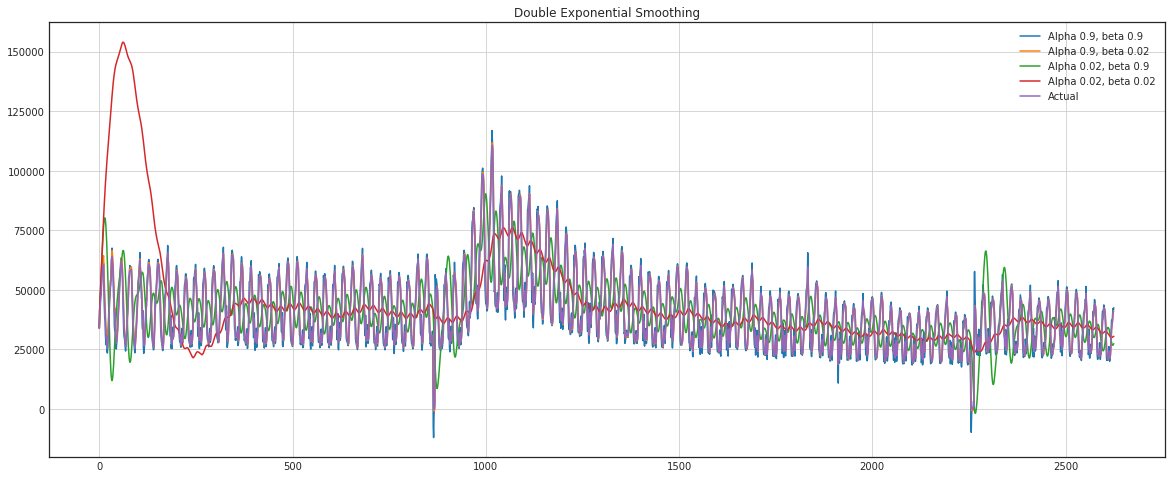

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(
                double_exponential_smoothing(dataset.Users, alpha, beta),
                label="Alpha {}, beta {}".format(alpha, beta),
            )
    plt.plot(dataset.Users.values, label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Теперь настраивать пришлось уже два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. А о не ручном подборе параметров расскажу чуть ниже, сразу после тройного экспоненциального сглаживания.

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters


Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже приведен код для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [12]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series):  # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

## Кросс-валидация на временных рядах

Перед тем, как построить модель, поговорим, наконец, о не ручной оценке параметров для моделей. 

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящуюю для данной задачи функцию потерь: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error), [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) и др., которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и опускаться в сторону глобального минимума ошибки. 

Небольшая загвоздка возникает только в кросс-валидации. Проблема состоит в том, что временной ряд имеет временную структуру, и случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать способ для оптимизации параметров "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Код для кросс-валидации на временном ряду. Значение длины сезона 24\*7 возникло не случайно - в исходном ряде отчетливо видна дневная сезонность, (отсюда 24), и недельная - по будням ниже, на выходных - выше, (отсюда 7), суммарно сезонных компонент получится 24\*7.

In [13]:
from sklearn.model_selection import TimeSeriesSplit


def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=24 * 7,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров - каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае - Truncated Newton conjugate gradient(Усеченный Метод Ньютона).

In [14]:
%%time
data = dataset.Users[:-500]  # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006634267064344168 0.0 0.0467652042896729
CPU times: user 33.4 s, sys: 75.7 ms, total: 33.4 s
Wall time: 33.5 s


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов)

In [15]:
# Передаем оптимальные значения модели,
data = dataset.Users
model = HoltWinters(
    data[:-128],
    slen=24 * 7,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=128,
    scaling_factor=2.56,
)
model.triple_exponential_smoothing()

Код для отрисовки графика

In [16]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN] * len(data))
    Anomalies[data.values < model.LowerBond] = data.values[
        data.values < model.LowerBond
    ]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(
        x=range(0, len(model.result)),
        y1=model.UpperBond,
        y2=model.LowerBond,
        alpha=0.5,
        color="grey",
    )
    plt.plot(data.values, label="Actual")
    plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 128, len(data), alpha=0.5, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

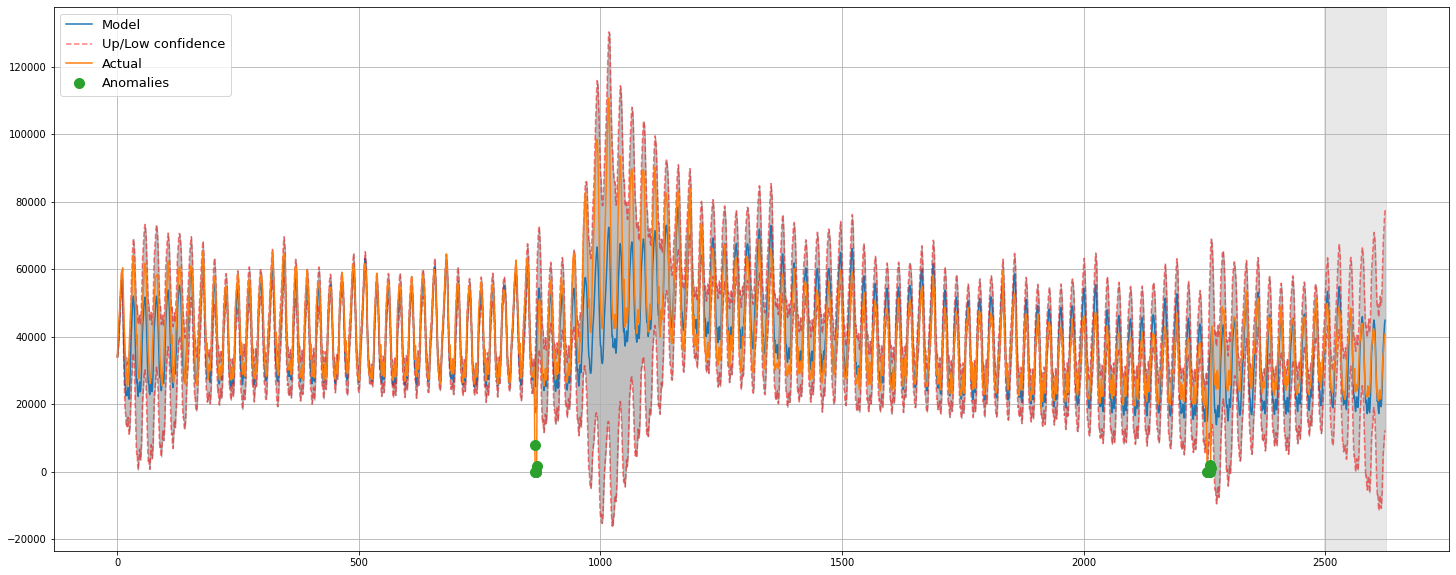

In [17]:
plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив недельную и дневную сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

# Эконометрический подход

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>



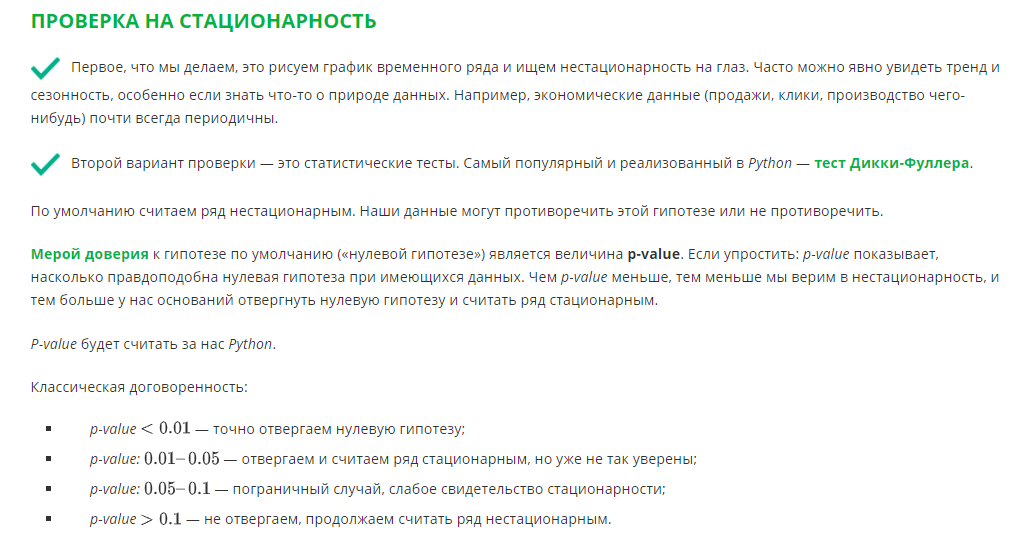

##Почему стационарность так важна?
 По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределами учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое.

График белого шума:

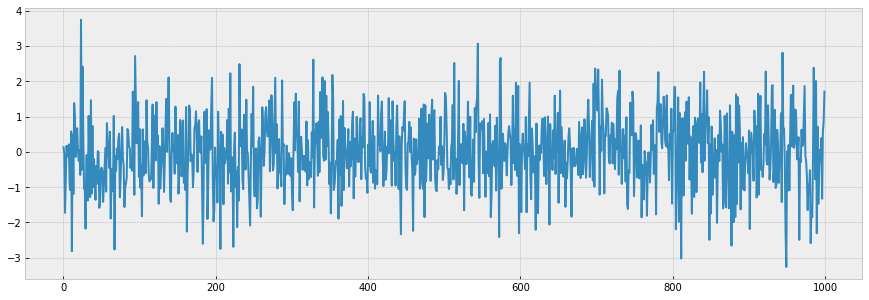

In [18]:
white_noise = np.random.normal(size=1000)
with plt.style.context("bmh"):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на его основе сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$ 

Код для отрисовки графиков

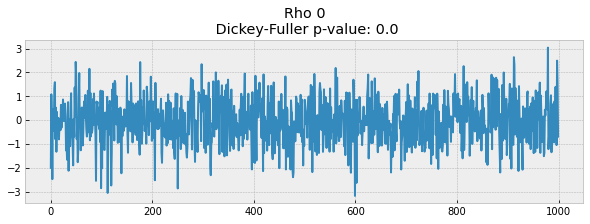

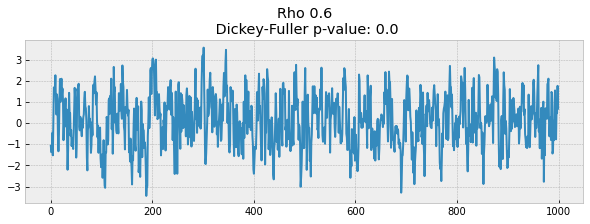

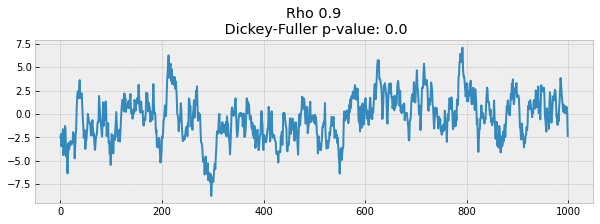

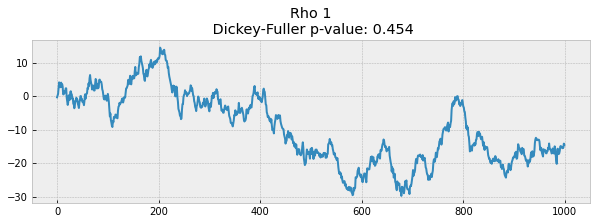

In [19]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t - 1] + w[t]

    with plt.style.context("bmh"):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title(
            "Rho {}\n Dickey-Fuller p-value: {}".format(
                rho, round(sm.tsa.stattools.adfuller(x)[1], 3)
            )
        )


for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение $\rho$ увеличилось до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания - ряд не стационарен.

Бороться с нестационарностью можно множеством способов - разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## <center>Часть 2. Смерти из-за несчастного случая в США</center>
Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [20]:

plt.rcParams["figure.figsize"] = 12, 10
from itertools import product
import statsmodels.api as sm
from scipy import stats


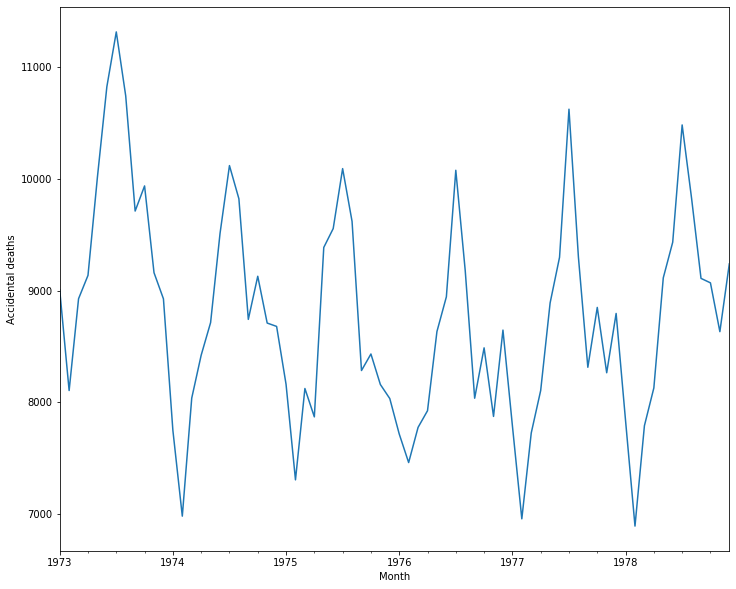

In [21]:
deaths = pd.read_csv(dir_data+'accidental-deaths-in-usa-monthly.csv',
    index_col=["Month"],
    parse_dates=["Month"])
deaths.rename(
    columns={"Accidental deaths in USA: monthly, 1973 ? 1978": "num_deaths"},
    inplace=True,
)
deaths["num_deaths"].plot()
plt.ylabel("Accidental deaths");

Проверка стационарности и декомпозиция ряда:

Критерий Дики-Фуллера: p=0.102481


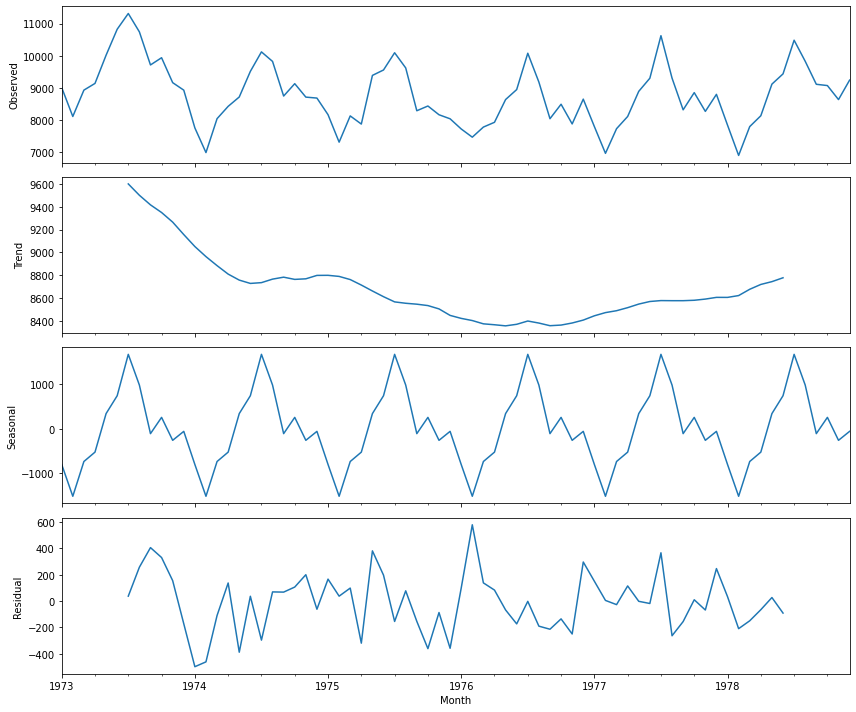

In [22]:
sm.tsa.seasonal_decompose(deaths["num_deaths"]).plot()
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths["num_deaths"])[1]
)

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, но небольшой тренд остался. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014650


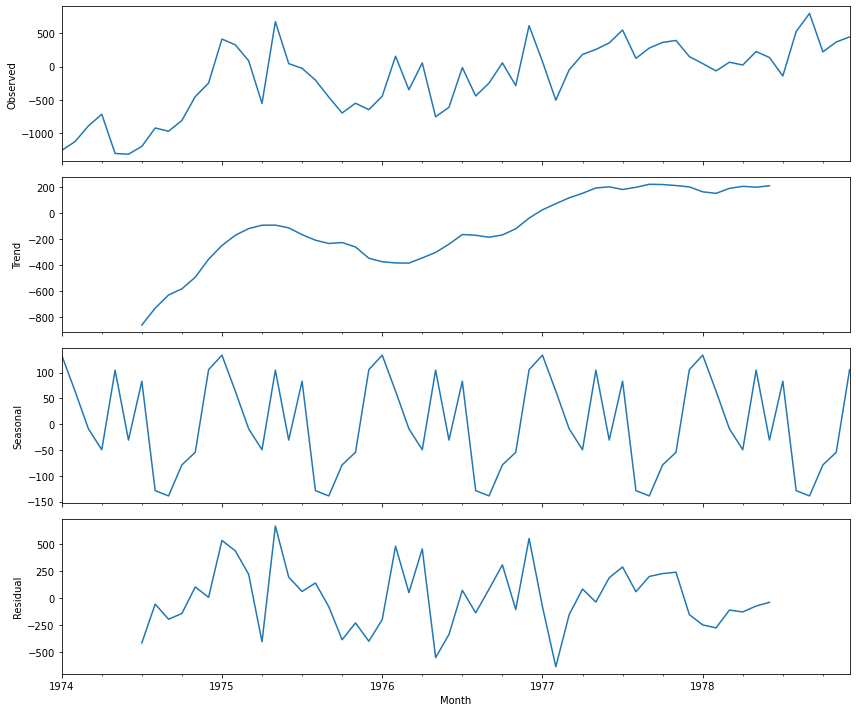

In [23]:
deaths["num_deaths_diff"] = deaths["num_deaths"] - deaths["num_deaths"].shift(12)
# deaths["num_deaths_diff"] = deaths["num_deaths"].diff(12)
sm.tsa.seasonal_decompose(deaths["num_deaths_diff"][12:]).plot()
print(
    "Критерий Дики-Фуллера: p=%f"
    % sm.tsa.stattools.adfuller(deaths["num_deaths_diff"][12:])[1]
)

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


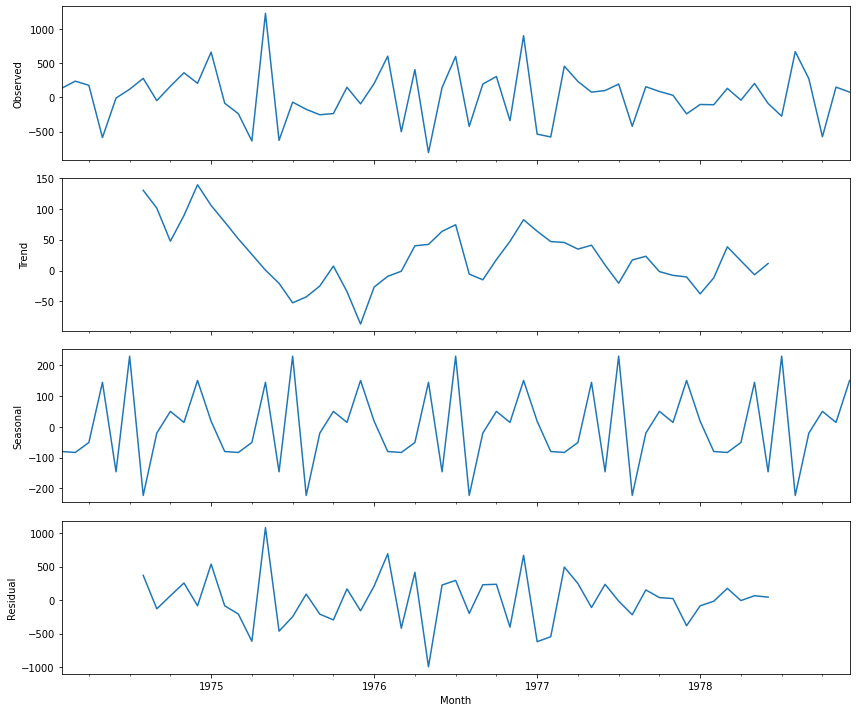

In [24]:
deaths["num_deaths_diff2"] = deaths["num_deaths_diff"] - deaths["num_deaths_diff"].shift(1)
# deaths["num_deaths_diff2"] = deaths["num_deaths_diff"].diff(1)
sm.tsa.seasonal_decompose(deaths["num_deaths_diff2"][13:]).plot()
print(
    "Критерий Дики-Фуллера: p=%f"
    % sm.tsa.stattools.adfuller(deaths["num_deaths_diff2"][13:])[1]
)

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет

## Подбор модели

Итак, предварительный анализ закончен, и мы можем перейти к построению сезонной модели ARIMA (SARIMA).
Общий вид данной модели SARIMA(p,d,q)(P,D,Q)_s
В этой модели параметры обозначают следующее:
- p — порядок модели AR(p)
- d — порядок интегрирования исходных данных
- q — порядок модели MA(q)
- P — порядок сезонной составляющей SAR(P)
- D — порядок интегрирования сезонной составляющей
- Q — порядок сезонной составляющей SMA(Q)
- s — размерность сезонности(месяц, квартал и т.д.)


Начнем с определения параметра D/d. Он определет порядок интегрированности сезонной разности/обычной разности, т.е. в нашем случае они равны 1. Для определения P,p и Q,q нам надо построить коррелограммы ACF и PACF.

Далее изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.

PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

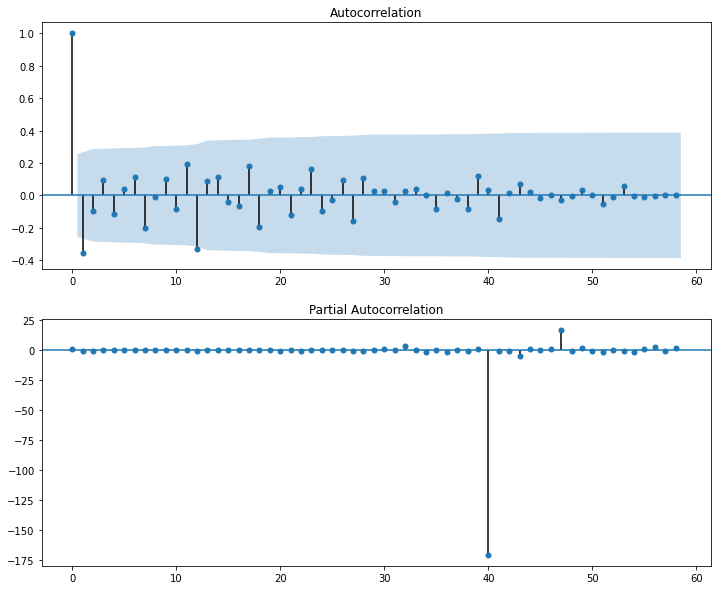

In [25]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    deaths["num_deaths_diff2"][13:].values.squeeze(), lags=58, ax=ax
)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    deaths["num_deaths_diff2"][13:].values.squeeze(), lags=58, ax=ax
);

In [26]:
ps = range(0, 3)
d = 1
qs = range(0, 1)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)

# product(*iterables, repeat=1) - аналог вложенных циклов.
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)


In [27]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0, 2),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 1, 2),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 0, 2, 2),
 (2, 0, 0, 0),
 (2, 0, 0, 1),
 (2, 0, 0, 2),
 (2, 0, 1, 0),
 (2, 0, 1, 1),
 (2, 0, 1, 2),
 (2, 0, 2, 0),
 (2, 0, 2, 1),
 (2, 0, 2, 2)]

In [ ]:
%%time
results = []
best_aic = float("inf")


for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            deaths["num_deaths"],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12),
        ).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [29]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

      parameters         aic
13  (2, 0, 0, 1)  854.647098
7   (1, 0, 0, 1)  855.458079
16  (2, 0, 2, 0)  856.494101
15  (2, 0, 1, 1)  856.614483
10  (1, 0, 2, 0)  856.648917


Посмотрим на остатки:

Критерий Стьюдента: p=0.274373
Критерий Дики-Фуллера: p=0.000000


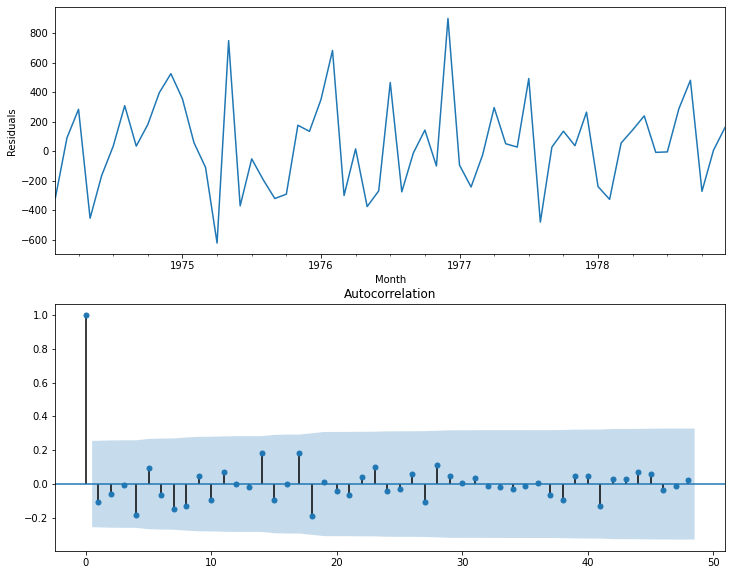

In [30]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
)

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

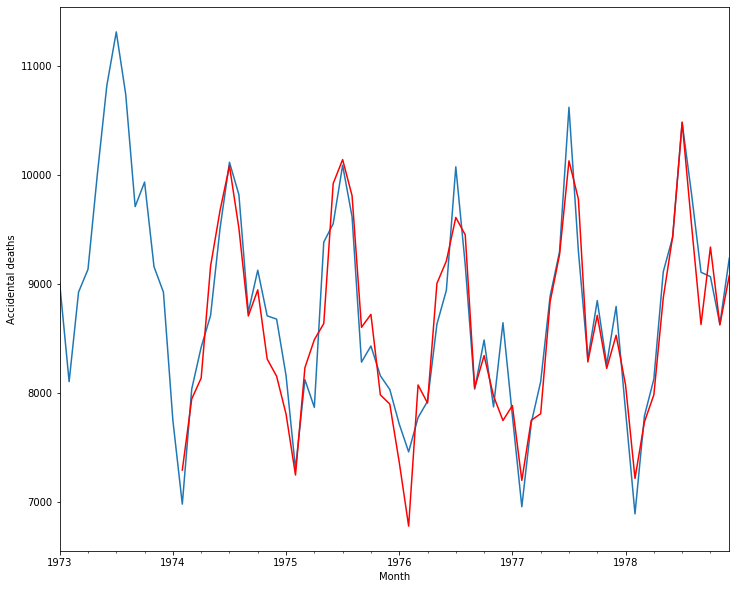

In [31]:
deaths["model"] = best_model.fittedvalues
deaths["num_deaths"].plot()
deaths["model"][13:].plot(color="r")
plt.ylabel("Accidental deaths");

In [32]:

#Defining MAPE function
def MAPE(actual,predicted):
    mape = np.mean(np.abs((actual - predicted)/actual))*100
    return mape

In [33]:
MAPE(deaths.num_deaths,deaths.model)

5.768821352580779

##Прогноз

In [34]:
deaths

,num_deaths,num_deaths_diff,num_deaths_diff2,model
Month,,,,
1973-01-01,9007,NaN,NaN,0.000000
1973-02-01,8106,NaN,NaN,8823.426829
1973-03-01,8928,NaN,NaN,8086.458806
1973-04-01,9137,NaN,NaN,8955.774411
1973-05-01,10017,NaN,NaN,9103.728507
...,...,...,...,...
1978-08-01,9827,525.0,666.0,9540.021612
1978-09-01,9110,796.0,271.0,8630.213165
1978-10-01,9070,220.0,-576.0,9341.519804


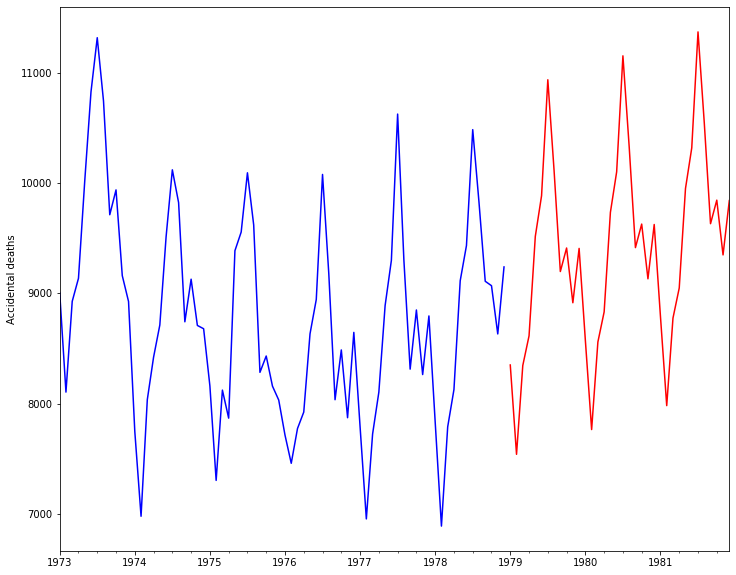

In [37]:
from dateutil.relativedelta import relativedelta

deaths2 = deaths[["num_deaths"]]
date_list = [
    pd.datetime.strptime("1979-01-01", "%Y-%m-%d") + relativedelta(months=x)
    for x in range(0, 36)
]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2["forecast"] = best_model.predict(start=72, end=150)

deaths2["num_deaths"].plot(color="b")
deaths2["forecast"].plot(color="r")
plt.ylabel("Accidental deaths");